In [1]:
from pyscf import gto, scf
import scipy
import inspect
import pyscf.qmmm
import pyscf.dft
import numpy as np
angstrom = 1 / 0.52917721067
from matplotlib import pyplot as plt
from functools import reduce
from numpy.linalg import inv 
# ancora il modo migliore per mettere cariche frazionali sulle molecole, se vai a toccare mol.charges si incazza 
#  quando deve calcolare l' initial guess 
def fc(calc,deltaZ):
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords()/angstrom, deltaZ)  # now is add_mm_charge
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float).copy()
            q1 =q+ np.asarray(deltaZ) 
            return self.mol.energy_nuc(q1)
    return(NoSelfQMMM(mf,mf.mm_mol))

def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1]/angstrom)
    dV+=mol.intor('int1e_rinv')*dL[1]
    return dV

In [2]:
molhh=gto.Mole(atom="H 0 0 0 ; H 0 0 .66",basis="sto-3G")
hf=scf.RHF(molhh)
hf.scf()
"""
a=.005
mf = pyscf.qmmm.mm_charge(hf, hf.mol.atom_coords()/angstrom, [-a,a])
class NoSelfQMMM(mf.__class__):
    def energy_nuc(self):
        q = self.mol.atom_charges().astype(np.float)
        q1 =q+ np.asarray([-a,a]) 
        return self.mol.energy_nuc(q1)
NoSelfQMMM(mf,mf.mm_mol()).scf()"""

Initialize <pyscf.gto.mole.Mole object at 0x7f39e05e2a90> in <pyscf.scf.hf.RHF object at 0x7f39e05e2cd0>


converged SCF energy = -1.11439653848583


'\na=.005\nmf = pyscf.qmmm.mm_charge(hf, hf.mol.atom_coords()/angstrom, [-a,a])\nclass NoSelfQMMM(mf.__class__):\n    def energy_nuc(self):\n        q = self.mol.atom_charges().astype(np.float)\n        q1 =q+ np.asarray([-a,a]) \n        return self.mol.energy_nuc(q1)\nNoSelfQMMM(mf,mf.mm_mol()).scf()'

In [3]:
scf.RHF(gto.Mole(atom="He 0 0 0",basis="sto-3g")).scf()

Initialize <pyscf.gto.mole.Mole object at 0x7f39e05f08d0> in <pyscf.scf.hf.RHF object at 0x7f39b336ae10>


converged SCF energy = -2.80778395753998


-2.807783957539976

converged SCF energy = -2.63149932807124
converged SCF energy = -2.11690580173753
converged SCF energy = -1.6951557154718
converged SCF energy = -1.37878758687923
converged SCF energy = -1.18154401517
converged SCF energy = -1.11439653848583
converged SCF energy = -1.1815440150563
converged SCF energy = -1.37878758666557
converged SCF energy = -1.69515571517901
converged SCF energy = -2.11690580138533
converged SCF energy = -2.63149932767394


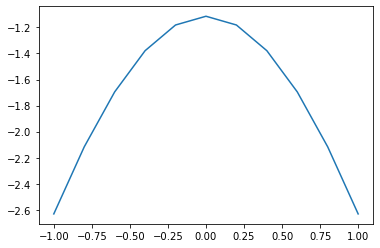

In [4]:
plt.plot(np.linspace(-1,1,11),[fc(hf,[a,-a]).scf() for a in np.linspace(-1,1,11)])

In [5]:
S=hf.get_ovlp()
C=hf.mo_coeff
O1=hf.mo_occ
O=np.diag(O1)
P=hf.make_rdm1()
F=hf.get_fock()
h1=hf.get_hcore()
h2=hf.get_veff()
J,K=hf.get_jk()
g_ijkl=hf.mol.intor('int2e_sph')
E=np.diag(hf.mo_energy)
print('COC* = P :', np.allclose(P,C.dot(O.dot(C.T)))) 
print( "J-K/2 = H2 :",np.allclose(h2,J-K/2))
print("J= sum_ij(g_ijkl P_kl ) ",np.allclose(J,np.einsum('ijkl,kl->ij',g_ijkl,P)))
print("K= sum_ik(g_ijkl P_jl ) ",np.allclose(K,np.einsum('ijkl,jl->ik',g_ijkl,P)))

print( "F= H1 +H2 :",np.allclose(F,h1+h2))
print ("numero di elettroni:", S.dot(P).trace())  # numero di elettroni
print("FC=SCE :",np.allclose(np.dot(F,C),S.dot(C.dot(E))))
print("eig(S-1 F) -> C,E ",np.linalg.eig(np.linalg.inv(S).dot(F)),C,np.diag(E))
print("C*FC = E : ",np.allclose(C.T.dot(F.dot(C))/100,E/100))

COC* = P : True
J-K/2 = H2 : True
J= sum_ij(g_ijkl P_kl )  True
K= sum_ik(g_ijkl P_jl )  True
F= H1 +H2 : True
numero di elettroni: 2.0
FC=SCE : True
eig(S-1 F) -> C,E  (array([-0.61308703,  0.76077336]), array([[-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])) [[ 0.54037238 -1.31833743]
 [ 0.54037238  1.31833743]] [-0.61308703  0.76077336]
C*FC = E :  True


$$ J - K/2 =H_2$$
$$H_1+ H_2 = F $$

$$ V_{ij}^{\alpha} = \sum_{kl} (ij|kl)(\gamma_{lk}^\alpha+\gamma_{lk}^\beta)- \sum_{kl} (il|kj) \gamma_{lk}^{\alpha} \\    V_{ij}^{\beta}  = \sum_{kl} (ij|kl)(\gamma_{lk}^{\alpha}+\gamma_{lk}^{\beta})  - \sum_{kl} (il|kj)\gamma_{lk}^\beta $$

Now getting the energies

$$  E = \sum_{ij}h_{ij} \gamma_{ji} + \frac{1}{2}\sum_{ijkl} \gamma_{ji}\gamma_{lk} \langle ik||jl\rangle $$


In [6]:
e_tot=hf.e_tot 
e_nn=hf.energy_nuc() 
e_ne,e_ee=hf.energy_elec()
e_ne-=e_ee

In [7]:
print(e_tot,e_nn+e_ee+e_ne)
print(e_ne,np.trace(P.dot(h1)))
print(e_ee,np.trace(P.dot(h2))/2)

-1.114396538485826 -1.114396538485826
-2.6061863152003397 -2.6061863152003397
0.6900061238054227 0.6900061238054227


Now is to get the alchemical derivatives:
$$ $$

In [8]:
hf0=fc(hf,[.005,-.005])
hf0.scf()
C0=hf0.mo_coeff
P0=hf0.make_rdm1()

hf1=fc(hf,[-.005,.005])
hf1.scf()
C1=hf1.mo_coeff
P1=hf1.make_rdm1()
dV=hf1.get_hcore()-hf.get_hcore()

converged SCF energy = -1.11443873633341
converged SCF energy = -1.11443873633631


In [9]:
dC=(abs(C1)*C/abs(C)-C)  # avoid change sign
dP=(P1-P)
dF=(hf1.get_fock()-F)
dC

array([[-0.00396422, -0.00161794],
       [ 0.00395934, -0.00162984]])

In [10]:
print(C0)
print(C)
print(abs(C1)*C/abs(C))

[[ 0.54433171 -1.31670758]
 [ 0.53640816  1.31995537]]
[[ 0.54037238 -1.31833743]
 [ 0.54037238  1.31833743]]
[[ 0.53640816 -1.31995537]
 [ 0.54433171  1.31670758]]


In [11]:
print(P0)
print(P)
print(P1)

[[0.59259403 0.58396794]
 [0.58396794 0.57546742]]
[[0.58400461 0.58400461]
 [0.58400461 0.58400461]]
[[0.57546742 0.58396794]
 [0.58396794 0.59259403]]


In [12]:
J1,K1=hf1.get_jk()

In [13]:
dP,dC.dot(O.dot(C.T))+C.dot(O.dot(dC.T))+0.5*dC.dot(O.dot(dC.T)) #last term is 2nd order will neglet

(array([[-8.53718548e-03, -3.66654087e-05],
        [-3.66654087e-05,  8.58942014e-03]]),
 array([[-8.55290051e-03, -2.09697300e-05],
        [-2.09697300e-05,  8.57374379e-03]]))

In [14]:
#dF=dV+dC*h2
print(dF),print(dV+(np.einsum('ijkl,kl->ij',g_ijkl,dP))\
                                  -0.5*np.einsum('ijkl,jl->ik',g_ijkl,dP))
print("------------------------------------")
print(hf1.get_fock()-F),print(dV+(np.einsum('ijkl,kl->ij',g_ijkl,(dC.dot(O.dot(C.T))+C.dot(O.dot(dC.T))))\
                                  -0.5*np.einsum('ijkl,jl->ik',g_ijkl,(dC.dot(O.dot(C.T))+C.dot(O.dot(dC.T))))))


[[ 2.90091574e-03  4.38569015e-06]
 [ 4.38569015e-06 -2.89456664e-03]]
[[ 2.90091574e-03  4.38569015e-06]
 [ 4.38569015e-06 -2.89456664e-03]]
------------------------------------
[[ 2.90091574e-03  4.38569015e-06]
 [ 4.38569015e-06 -2.89456664e-03]]
[[ 2.89087616e-03 -3.80357809e-06]
 [-3.80357809e-06 -2.90460902e-03]]


(None, None)

In [15]:
#dF*C+F*dC=SdCE
dF.dot(C)+F.dot(dC),S.dot(dC.dot(E))

(array([[ 0.00070542, -0.00211254],
        [-0.00069213, -0.00211834]]),
 array([[ 0.00070132, -0.00211411],
        [-0.0006962 , -0.00211672]]))

In [16]:
U=np.linalg.inv(C).dot(dC)
C.dot(U),dC

(array([[-0.00396422, -0.00161794],
        [ 0.00395934, -0.00162984]]),
 array([[-0.00396422, -0.00161794],
        [ 0.00395934, -0.00162984]]))

In [17]:
C.T.dot(dF.dot(C)),U.dot(E)-E.dot(U)

(array([[ 4.41521656e-06, -4.12866182e-03],
        [-4.12866182e-03, -4.20994734e-06]]),
 array([[ 0.        , -0.00412863],
        [-0.00412863,  0.        ]]))

In [18]:
C.T.dot(dV.dot(C))

array([[-7.26633597e-13, -3.68589661e-03],
       [-3.68589661e-03,  4.11000227e-13]])

In [19]:
print (dF,dV)

[[ 2.90091574e-03  4.38569015e-06]
 [ 4.38569015e-06 -2.89456664e-03]] [[ 2.58698215e-03 -6.81232848e-13]
 [-6.81232848e-13 -2.58698215e-03]]


In [20]:
(np.einsum('ijkl,kl->ij',g_ijkl,(dC.dot(O.dot(C.T))+C.dot(O.dot(dC.T))))\
                                  -0.5*np.einsum('ijkl,jl->ik',g_ijkl,(dC.dot(O.dot(C.T))+C.dot(O.dot(dC.T)))))

array([[ 3.03894013e-04, -3.80357741e-06],
       [-3.80357741e-06, -3.17626874e-04]])

In [21]:
G_mo=np.zeros(g_ijkl.shape)
for a in range(2):
    for b in range(2):
        for c in range(2):
            for d in range(2):
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            for l in range(2):
                                G_mo[a][b][c][d]+= C[i][a]*C[j][b]*C[k][c]*C[l][d]*g_ijkl[i][j][k][l]
G_mo

array([[[[ 6.90006124e-01,  5.55111512e-17],
         [ 0.00000000e+00,  6.77879609e-01]],

        [[ 1.11022302e-16,  1.76847528e-01],
         [ 1.76847528e-01,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  1.76847528e-01],
         [ 1.76847528e-01, -2.22044605e-16]],

        [[ 6.77879609e-01,  1.11022302e-16],
         [ 3.33066907e-16,  7.12736018e-01]]]])

In [22]:
C.T.dot(np.einsum('ijkl,kl->ij',g_ijkl,dP).dot(C)),\
np.einsum('ijkl,kl->ij',G_mo,U)

(array([[-2.19024700e-07,  2.12579104e-03],
        [ 2.12579104e-03,  6.29563776e-07]]),
 array([[-6.17657763e-06, -4.87941109e-18],
        [-4.66206934e-18, -6.27921263e-06]]))


# Density matrix purification

$$ P+\Delta P = (P+\Delta P)S_N(P+\Delta P)/2$$
At the first order in $\Delta P$
$$(P-PS_NP)/2 + \Delta P = PS_N \Delta P$$
$$ \Delta P = (1-PS_N)^{-1} (PS_NP-P) /2 $$ 
<br>oppure :
$$ \Delta P = (PS_N \Delta P + \Delta PS_NP )/2 $$
se $P=P^\dagger$
$$ \Delta P =\Delta PS_NP$$
$$ \Delta P = \alpha (S_NP-1)^{-1} $$
and from 
$$ tr(PS)=N_e$$
$$ tr(\Delta P S )=0 $$
$$P_{purified} = 3P^2 -2P^3 $$


In [28]:
print(dP)
print((S.dot(dP).trace()))

[[-8.53718548e-03 -3.66654087e-05]
 [-3.66654087e-05  8.58942014e-03]]
-1.700029006457271e-16


In [29]:
P,3*P.dot(S.dot(P/2))-2*P.dot((S.dot(P.dot(S.dot(P/4)))))

(array([[0.58400461, 0.58400461],
        [0.58400461, 0.58400461]]),
 array([[0.58400461, 0.58400461],
        [0.58400461, 0.58400461]]))

In [30]:
dV+dC.dot(h2)

array([[-0.00110857, -0.0028998 ],
       [ 0.00232396, -0.00215862]])

In [31]:
hf1.get_hcore()-hf.get_hcore()

array([[ 2.58698215e-03, -6.81232848e-13],
       [-6.81232848e-13, -2.58698215e-03]])

Prima approsimazione stupida è di fare dF==dV e scrivere
$$ C^\dagger \frac{\partial F}{\partial Z_\alpha} C =C^\dagger \frac{\partial V_{ne}}{\partial Z_\alpha} C = UE - EU $$
E poi posso anche scomporre:
$$ \left( UE - EU \right)_{ij} = \sum_k U_{ik}\delta_{kj} \epsilon_j - \epsilon_i \delta_{ik} U_{kj} = U_{ij}(\epsilon_j - \epsilon_i)$$
e quindi:
$$ U_{ij} \approx \left ( C^\dagger \frac{\partial V_{ne}}{\partial Z_\alpha} C \right)_{ij} / (\epsilon_j - \epsilon_i) $$
ove $(\epsilon_j - \epsilon_i) \ne 0 $

In [39]:
print(E)
e=np.diag(E)
print(U.dot(E)-E.dot(U))

[[-0.61308703  0.        ]
 [ 0.          0.76077336]]
[[ 0.         -0.00412863]
 [-0.00412863  0.        ]]


array([-0.61308703,  0.76077336])

In [41]:
print (U[0,1]*(e[1]-e[0]))

-0.004128631812990197


In [45]:
E_E=np.zeros([2,2])
E_E[0,1]=(e[1]-e[0])
E_E[1,0]=(e[0]-e[1])
E_E

array([[ 0.       ,  1.3738604],
       [-1.3738604,  0.       ]])

In [47]:
print(U)
print((U.dot(E)-E.dot(U)))
print((U.dot(E)-E.dot(U))/E_E)

[[-4.51541929e-06 -3.00513198e-03]
 [ 3.00513198e-03 -4.51541929e-06]]
[[ 0.         -0.00412863]
 [-0.00412863  0.        ]]
[[        nan -0.00300513]
 [ 0.00300513         nan]]


/home/giorgiod/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
print(C.T.dot(dV.dot(C))/E_E)
U_app=C.T.dot(dV.dot(C))  # approximate value of U
for i in range(2):
    for j in range(2):
        if e[i]!=e[j]:
            U_app[i][j]/=(e[j]-e[i])
print(U_app)

[[       -inf -0.00268288]
 [ 0.00268288         inf]]
[[-7.26633597e-13 -2.68287565e-03]
 [ 2.68287565e-03  4.11000227e-13]]


/home/giorgiod/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [64]:
print(dC)
print(C.dot(U_app))

[[-0.00396422 -0.00161794]
 [ 0.00395934 -0.00162984]]
[[-0.00353694 -0.00144975]
 [ 0.00353694 -0.00144975]]
